In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import sys

In [2]:
project_root = os.path.abspath("..")
sys.path.insert(0, project_root)

from tools.body_parts_map import keypoint_map

In [3]:
body_parts_map = {
    "head": [0, 1, 2, 3, 4],
    "left_arm": [5, 7, 9],
    "right_arm": [6, 8, 10],
    "torso": [5, 6, 11, 12],
    "left_hand": list(range(12, 34)),
    "right_hand": list(range(34, 55)),
}

face_parts_map = {
    "face_contour": list(range(0, 17)),
    "nose": list(range(27, 36)),
    "right_eye": list(range(17, 22)) + list(range(36, 42)),
    "left_eye": list(range(22, 27)) + list(range(42, 48)),
    "mouth": list(range(48, 68)),
}

## Integrated Gradients

In [ ]:
import os
import json
import numpy as np

# Define the directory containing the JSON files
results_dir = os.path.join(project_root, "gradient_saliency", "results", "integrated_gradients_top_10_face_body")

# Initialize variables to store cumulative saliency scores and counts
cumulative_face_saliency = None
cumulative_body_saliency = None
file_count = 0

# Iterate through all JSON files in the directory
for filename in os.listdir(results_dir):
    if filename.endswith(".json"):
        file_path = os.path.join(results_dir, filename)
        with open(file_path, "r") as f:
            data = json.load(f)
        
        # Extract face and body saliency scores
        face_saliency = np.array(data["results"]["face_saliency"])
        body_saliency = np.array(data["results"]["body_saliency"])
        mix_saliency = np.array(data["results"]["mix_saliency"])

        # Initialize cumulative arrays if not already done
        if cumulative_face_saliency is None:
            cumulative_face_saliency = np.zeros_like(face_saliency)
        if cumulative_body_saliency is None:
            cumulative_body_saliency = np.zeros_like(body_saliency)
        if mix_saliency is None:
            mix_saliency = np.zeros_like(mix_saliency)
        
        # Accumulate saliency scores
        cumulative_face_saliency += face_saliency
        cumulative_body_saliency += body_saliency
        mix_saliency += mix_saliency
        file_count += 1

# Calculate the average saliency scores
if file_count > 0:
    average_face_saliency = cumulative_face_saliency / file_count
    average_body_saliency = cumulative_body_saliency / file_count
    average_mix_saliency = mix_saliency / file_count
    print("Average face saliency, body saliency, and mix saliency calculated.")
else:
    print("No JSON files found in the directory.")

Average face saliency and body saliency calculated.


### Average analysis

In [10]:
face_keypoint_names = []
body_keypoint_names = []

face_start_index = 23
for i in range(len(average_face_saliency)):
    face_keypoint_names.append(keypoint_map[i + face_start_index])

lower_body_start_index = 13
for i in range(len(average_body_saliency)):
    index = i
    if index >= lower_body_start_index:
        index = (
            i
            + len(average_face_saliency)
            + face_start_index
            - lower_body_start_index
        )
    body_keypoint_names.append(keypoint_map[index])

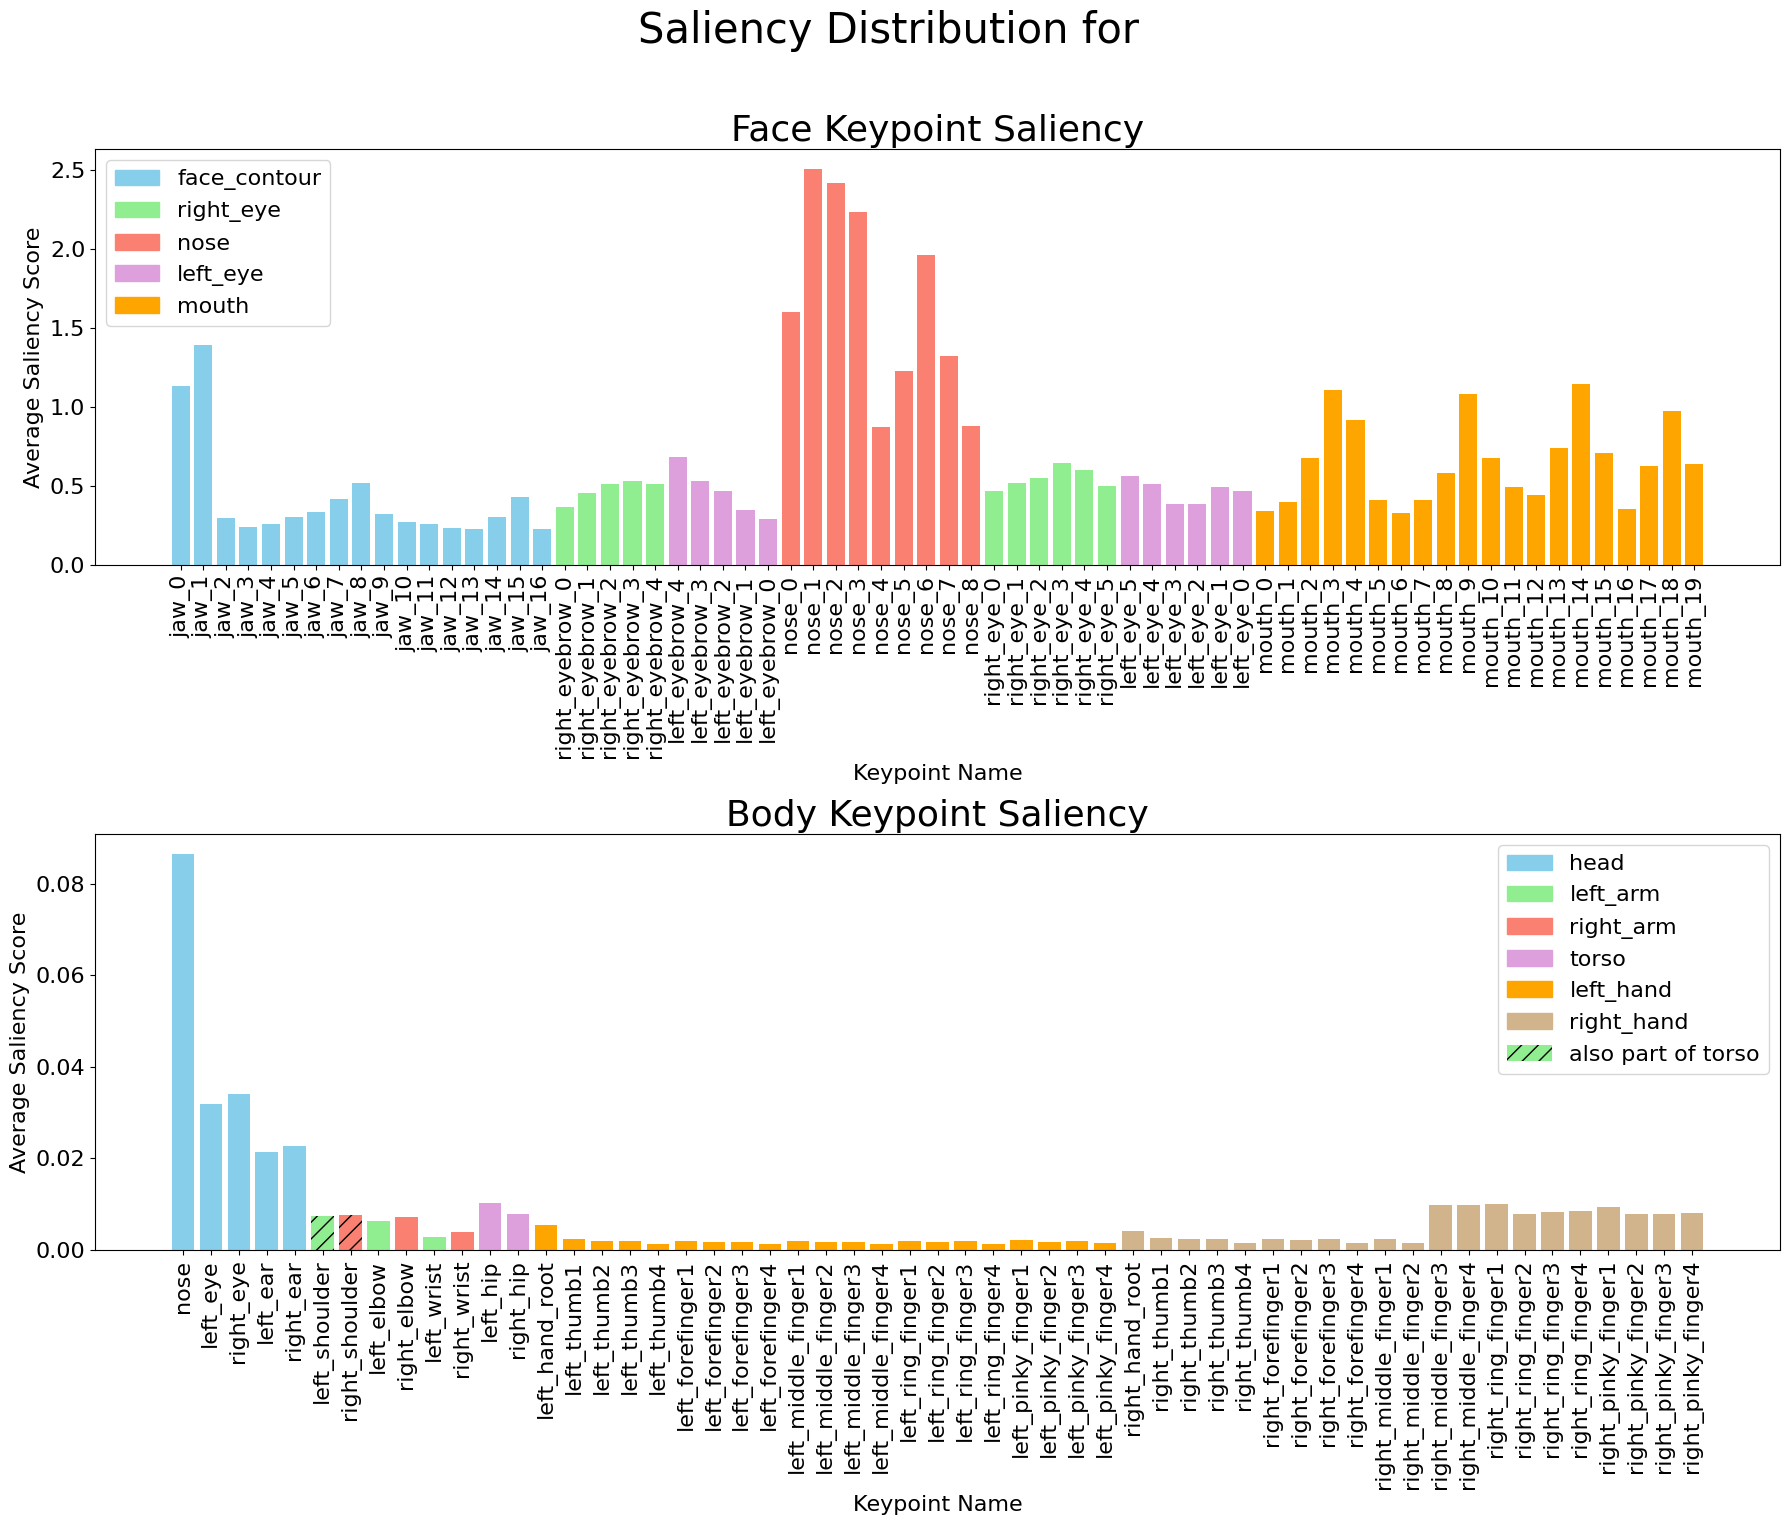

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(18, 16))
fig.suptitle(f"Saliency Distribution for ", fontsize=30)

# Define colors for different face parts
face_colors = {
    "face_contour": "skyblue",
    "right_eye": "lightgreen",
    "nose": "salmon",
    "left_eye": "plum",
    "mouth": "orange",
}

# Define colors for different body parts
body_colors = {
    "head": "skyblue",
    "left_arm": "lightgreen",
    "right_arm": "salmon",
    "torso": "plum",
    "left_hand": "orange",
    "right_hand": "tan",
}

# --- Plot 1: Face Keypoints ---
bar_colors_face = []
for i in range(len(average_face_saliency)):
    # Find which part this keypoint belongs to
    for part_name, indices in face_parts_map.items():
        if i in indices:
            bar_colors_face.append(face_colors[part_name])
            break

bars_face = axes[0].bar(
    face_keypoint_names, average_face_saliency, color=bar_colors_face
)
axes[0].set_title("Face Keypoint Saliency", fontsize=26)
axes[0].set_xlabel("Keypoint Name", fontsize=16)
axes[0].set_ylabel("Average Saliency Score", fontsize=16)
axes[0].tick_params(axis="x", rotation=90, labelsize=16)
axes[0].tick_params(axis="y", labelsize=16)


# Add legend for face parts
legend_elements_face = [
    plt.Rectangle((0, 0), 1, 1, color=color, label=part)
    for part, color in face_colors.items()
]
axes[0].legend(handles=legend_elements_face, loc="upper left", fontsize=16)

# --- Plot 2: Body Keypoints ---
bar_colors_body = []
hatches = []

for i in range(len(average_body_saliency)):
    # Special handling for shoulder keypoints (dual membership)
    if body_keypoint_names[i] == "left_shoulder":
        bar_colors_body.append(body_colors["left_arm"])
        hatches.append(
            "//"
        )  # Hatching to indicate it's also part of the torso
    elif body_keypoint_names[i] == "right_shoulder":
        bar_colors_body.append(body_colors["right_arm"])
        hatches.append(
            "//"
        )  # Hatching to indicate it's also part of the torso
    else:
        # Find which part this keypoint belongs to
        hatches.append("")
        found = False
        for part_name, indices in body_parts_map.items():
            if i in indices:
                bar_colors_body.append(body_colors[part_name])
                found = True
                break
            # Special case for indices that need remapping
            elif i >= 13 and (i + 10) in indices:
                bar_colors_body.append(body_colors[part_name])
                found = True
                break
        if not found:
            bar_colors_body.append("gray")  # Default color

bars_body = axes[1].bar(
    body_keypoint_names, average_body_saliency, color=bar_colors_body
)

# Add hatching to indicate dual membership
for bar, hatch in zip(bars_body, hatches):
    bar.set_hatch(hatch)

axes[1].set_title("Body Keypoint Saliency", fontsize=26)
axes[1].set_xlabel("Keypoint Name", fontsize=16)
axes[1].set_ylabel("Average Saliency Score", fontsize=16)
axes[1].tick_params(axis="x", rotation=90, labelsize=16)
axes[1].tick_params(axis="y", labelsize=16)


# Add legend for body parts
legend_elements_body = [
    plt.Rectangle((0, 0), 1, 1, color=color, label=part)
    for part, color in body_colors.items()
]

# Add special legend entry for dual membership with hatching
hatch_rect = mpatches.Patch(
    facecolor=body_colors["left_arm"], hatch="//", label="also part of torso"
)
legend_elements_body.append(hatch_rect)

axes[1].legend(handles=legend_elements_body, loc="upper right", fontsize=16)

# --- Display the plot ---
plt.tight_layout(
    rect=[0, 0.03, 1, 0.96]
)  # Adjust layout to make room for suptitle
plt.show()

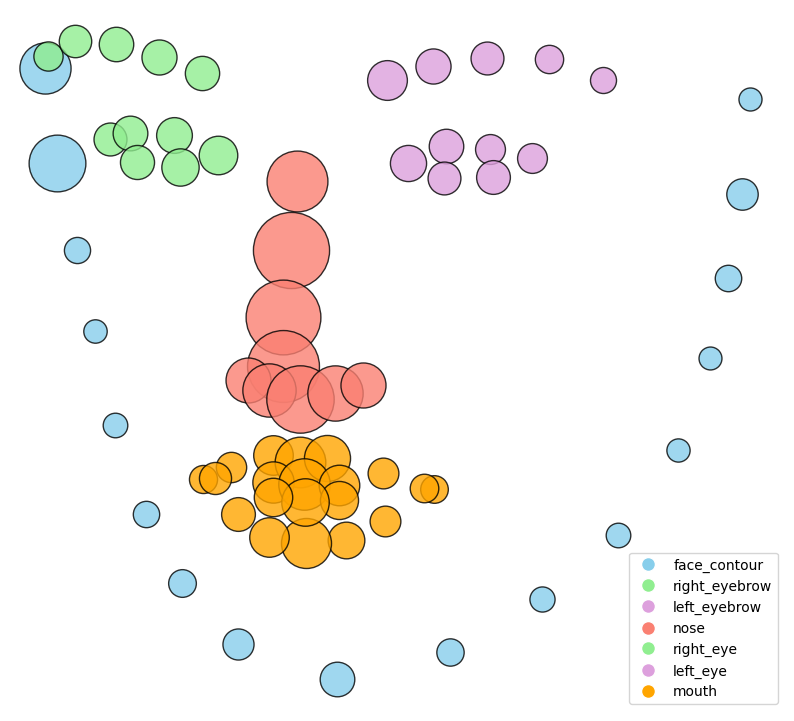

In [16]:
# Visualize face keypoints with colors and node sizes based on saliency scores
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_alpha(0)  # Make the figure background transparent
# ax.set_title("Face Keypoints Visualization", fontsize=20)
ax.set_aspect('equal')
ax.invert_yaxis() # Invert y-axis to match image coordinates
ax.axis("off")

# Corrected face parts map based on dlib 68 points
face_parts_map_viz = {
    "face_contour": list(range(0, 17)),
    "right_eyebrow": list(range(17, 22)),
    "left_eyebrow": list(range(22, 27)),
    "nose": list(range(27, 36)),
    "right_eye": list(range(36, 42)),
    "left_eye": list(range(42, 48)),
    "mouth": list(range(48, 68)),
}

# Corrected face colors to include eyebrows
face_colors_viz = {
    "face_contour": "skyblue",
    "right_eyebrow": "lightgreen",
    "left_eyebrow": "plum",
    "nose": "salmon",
    "right_eye": "lightgreen",
    "left_eye": "plum",
    "mouth": "orange",
}

x_coords = [9.53309692e+02, 9.54548950e+02, 9.56760986e+02, 9.58683655e+02,
            9.60770996e+02, 9.64171692e+02, 9.68030762e+02, 9.74057495e+02,
            9.84706482e+02, 9.96826599e+02, 1.00667865e+03, 1.01482703e+03,
            1.02136145e+03, 1.02475610e+03, 1.02670862e+03, 1.02824890e+03,
            1.02903064e+03, 9.53574463e+02, 9.56466736e+02, 9.60953003e+02,
            9.65588684e+02, 9.70107117e+02, 9.90044495e+02, 9.95026306e+02,
            1.00082202e+03, 1.00741144e+03, 1.01330688e+03, 9.80415649e+02,
            9.79671265e+02, 9.78883911e+02, 9.78881958e+02, 9.75142822e+02,
            9.77317810e+02, 9.80671204e+02, 9.84401855e+02, 9.87468201e+02,
            9.60236877e+02, 9.62462158e+02, 9.67183533e+02, 9.71929993e+02,
            9.67756348e+02, 9.63130066e+02, 9.92299561e+02, 9.96340698e+02,
            1.00110101e+03, 1.00567871e+03, 1.00141473e+03, 9.96181274e+02,
            9.70292175e+02, 9.73320679e+02, 9.77831360e+02, 9.80669128e+02,
            9.83602783e+02, 9.89638184e+02, 9.95051636e+02, 9.89803345e+02,
            9.85600342e+02, 9.81387329e+02, 9.77390991e+02, 9.74046021e+02,
            9.71515015e+02, 9.77758667e+02, 9.81116211e+02, 9.84933716e+02,
            9.94040466e+02, 9.84866272e+02, 9.81232361e+02, 9.77822815e+02]

y_coords = [6.27681396e+02, 6.37936584e+02, 6.47280457e+02, 6.55990601e+02,
            6.66087524e+02, 6.75589355e+02, 6.83066345e+02, 6.89605530e+02,
            6.93360413e+02, 6.90424255e+02, 6.84714600e+02, 6.77841614e+02,
            6.68785400e+02, 6.58901123e+02, 6.50303955e+02, 6.41177002e+02,
            6.31009033e+02, 6.26440186e+02, 6.24776855e+02, 6.25130615e+02,
            6.26449768e+02, 6.28179565e+02, 6.28934326e+02, 6.27492920e+02,
            6.26555786e+02, 6.26684204e+02, 6.28952148e+02, 6.39802612e+02,
            6.47265991e+02, 6.54425415e+02, 6.59756104e+02, 6.61216675e+02,
            6.62293945e+02, 6.63274963e+02, 6.62601440e+02, 6.61728027e+02,
            6.35295593e+02, 6.34618652e+02, 6.34935608e+02, 6.37044861e+02,
            6.38269958e+02, 6.37831360e+02, 6.37902893e+02, 6.36111572e+02,
            6.36421143e+02, 6.37352844e+02, 6.39433716e+02, 6.39456116e+02,
            6.71838928e+02, 6.70561707e+02, 6.69273254e+02, 6.69978577e+02,
            6.69562988e+02, 6.71253723e+02, 6.72972717e+02, 6.76383423e+02,
            6.78456299e+02, 6.78723877e+02, 6.78078430e+02, 6.75664856e+02,
            6.71775330e+02, 6.72169250e+02, 6.72374268e+02, 6.72526184e+02,
            6.72795532e+02, 6.74144653e+02, 6.74283936e+02, 6.73762817e+02]

dlib_face_keypoint_coords = list(zip(x_coords, y_coords))

# Plot each keypoint with size proportional to saliency and color based on region
for part_name, indices in face_parts_map_viz.items():
    for i in indices:
        x, y = dlib_face_keypoint_coords[i]
        saliency_score = average_face_saliency[i]
        size = saliency_score * 1200  # Scale saliency scores for visualization
        color = face_colors_viz[part_name]
        ax.scatter(x, y, s=size, color=color, alpha=0.8, edgecolor="black")

# Add legend for face parts
legend_elements = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=part)
    for part, color in face_colors_viz.items()
]
ax.legend(handles=legend_elements, loc="lower right", fontsize=10)

plt.show()

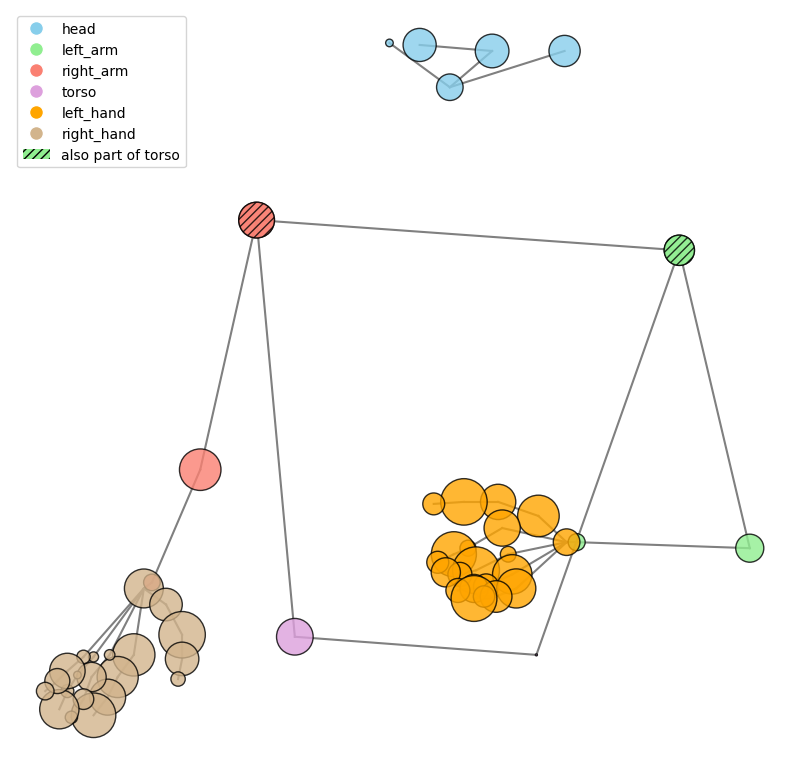

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Original body keypoints data (133 points)
body_keypoints_original = np.array([
    [ 979.9771,   656.0691 ], [ 999.7747,   639.09973], [ 965.836,    636.27155],
    [1033.7134,   639.09973], [ 951.6949,   635.3288 ], [1087.4497,   732.43115],
    [ 889.47394,  718.29004], [1120.4456,   871.9569 ], [ 863.07715,  835.19   ],
    [1039.3699,   869.12866], [ 840.45135,  887.9835 ], [1020.515,    921.9222 ],
    [ 907.38605,  913.4375 ], [1140.2432,   953.03265], [ 781.05865,  971.8875 ],
    [ 897.9586,  1010.5399 ], [ 976.2062,  1016.19635], [ 845.1651,  1032.2229 ],
    [ 850.82153, 1047.3068 ], [ 866.84814, 1021.8528 ], [1020.515,   1018.08185],
    [1046.9117,  1042.5931 ], [ 991.29004, 1026.5665 ], [ 950.75214,  628.7296 ],
    [ 950.75214,  639.09973], [ 951.6949,   648.52716], [ 953.5804,   657.9546 ],
    [ 955.4658,   667.382  ], [ 959.2368,   676.8094 ], [ 963.9505,   684.3513 ],
    [ 971.49243,  690.95056], [ 981.8626,   693.77875], [ 993.1755,   691.89325],
    [1004.4884,   686.2368 ], [1012.9731,   679.63763], [1019.57227,  672.0957 ],
    [1024.286,    662.6683 ], [1027.1143,   652.29816], [1028.9996,   642.8707 ],
    [1029.9424,   632.50055], [ 954.5231,   624.01587], [ 958.29407,  623.0732 ],
    [ 963.00775,  624.01587], [ 967.7215,   624.9586 ], [ 972.4352,   626.8441 ],
    [ 990.3473,   628.7296 ], [ 995.061,    626.8441 ], [1001.66016,  625.90137],
    [1008.25934,  626.8441 ], [1013.91583,  628.7296 ], [ 980.91986,  638.15704],
    [ 979.9771,   644.7562 ], [ 979.03436,  651.3554 ], [ 978.0916,   657.01184],
    [ 973.3779,   660.78284], [ 976.2062,   661.7255 ], [ 979.9771,   662.6683 ],
    [ 983.7481,   661.7255 ], [ 987.51904,  660.78284], [ 959.2368,   635.3288 ],
    [ 963.9505,   634.38605], [ 967.7215,   634.38605], [ 972.4352,   636.27155],
    [ 967.7215,   638.15704], [ 963.00775,  637.2143 ], [ 992.2328,   638.15704],
    [ 996.9465,   636.27155], [1001.66016,  637.2143 ], [1006.3739,   638.15704],
    [1001.66016,  640.0425 ], [ 996.9465,   640.0425 ], [ 966.77875,  671.15295],
    [ 971.49243,  670.2102 ], [ 977.1489,   669.26746], [ 979.9771,   670.2102 ],
    [ 982.80536,  670.2102 ], [ 989.40454,  671.15295], [ 996.0037,   673.03845],
    [ 989.40454,  676.8094 ], [ 984.69086,  678.6949 ], [ 979.03436,  678.6949 ],
    [ 974.3207,   677.75214], [ 970.5497,   674.92395], [ 967.7215,   671.15295],
    [ 975.2634,   672.0957 ], [ 979.9771,   673.03845], [ 984.69086,  673.03845],
    [ 995.061,    673.03845], [ 984.69086,  673.9812 ], [ 979.9771,   673.9812 ],
    [ 975.2634,   673.03845], [1034.6561,   869.12866], [1021.45776,  856.87305],
    [1002.6029,   850.27386], [ 986.5763,   850.27386], [ 972.4352,   851.2166 ],
    [1004.4884,   862.5295 ], [ 988.4618,   871.9569 ], [ 981.8626,   874.7851 ],
    [ 974.3207,   878.5561 ], [1007.31665,  874.7851 ], [ 992.2328,   882.327  ],
    [ 984.69086,  884.2125 ], [ 978.0916,   883.2698 ], [1009.2021,   884.2125 ],
    [ 996.9465,   889.86896], [ 991.29004,  890.8117 ], [ 983.7481,   891.75446],
    [1011.0876,   890.8117 ], [1001.66016,  894.5827 ], [ 996.0037,   894.5827 ],
    [ 991.29004,  895.52545], [ 836.6804,   890.8117 ], [ 847.0506,   898.35364],
    [ 854.5925,   912.4948 ], [ 854.5925,   923.8077 ], [ 852.70703,  933.2351 ],
    [ 831.96674,  921.9222 ], [ 824.4248,   932.29236], [ 819.71106,  941.7198 ],
    [ 813.1119,   950.20447], [ 820.6538,   921.9222 ], [ 812.1691,   932.29236],
    [ 808.3982,   942.66254], [ 802.7417,   951.14716], [ 813.1119,   922.8649 ],
    [ 805.56995,  931.3496 ], [ 800.85626,  938.89154], [ 797.08527,  947.3762 ],
    [ 808.3982,   922.8649 ], [ 800.85626,  929.4641 ], [ 796.1425,   934.17786],
    [ 790.4861,   938.89154]
])

# Indices to keep from the original 133 keypoints
indices_to_keep = (
    list(range(5)) + [5, 7, 9, 6, 8, 10, 11, 12] + list(range(91, 133))
)

# Filter the body keypoints to keep only the desired 55 points
body_keypoints = body_keypoints_original[indices_to_keep]

# Correct mapping for the 55 keypoints
body_parts_map_viz = {
    "head": list(range(0, 5)),
    "left_arm": [5, 6, 7], # Indices are now 5, 6, 7 in the 55-point array
    "right_arm": [8, 9, 10],
    "torso": [5, 8, 11, 12], # shoulders, hips
    "left_hand": list(range(13, 34)),
    "right_hand": list(range(34, 55)),
}

def _skeleton():
    # Skeleton connections for the 55-point model
    return [
        (0, 1), (1, 2), (0, 3), (0, 4), # Head
        (5, 8), # Connect shoulders
        (5, 6), (6, 7), # Left Arm
        (8, 9), (9, 10), # Right Arm
        (11, 12), # Hips
        (5, 11), (8, 12), # Torso connections
        # Left Hand
        (7, 13), # Connect arm to hand
        (13, 14), (14, 15), (15, 16), (16, 17),
        (13, 18), (18, 19), (19, 20), (20, 21),
        (13, 22), (22, 23), (23, 24), (24, 25),
        (13, 26), (26, 27), (27, 28), (28, 29),
        (13, 30), (30, 31), (31, 32), (32, 33),
        # Right Hand
        (10, 34), # Connect arm to hand
        (34, 35), (35, 36), (36, 37), (37, 38),
        (34, 39), (39, 40), (40, 41), (41, 42),
        (34, 43), (43, 44), (44, 45), (45, 46),
        (34, 47), (47, 48), (48, 49), (49, 50),
        (34, 51), (51, 52), (52, 53), (53, 54),
    ]

# Check if average_body_ig_saliency exists, if not create a placeholder
if 'average_body_ig_saliency' not in locals() or len(average_body_ig_saliency) != 55:
    print("Placeholder `average_body_ig_saliency` created. Replace with actual data.")
    average_body_ig_saliency = np.random.rand(55)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 12))
fig.patch.set_alpha(0)
# ax.set_title("Body Keypoints Saliency", fontsize=20)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.axis("off")

# Define colors for body parts
body_colors = {
    "head": "skyblue",
    "left_arm": "lightgreen",
    "right_arm": "salmon",
    "torso": "plum",
    "left_hand": "orange",
    "right_hand": "tan",
}

# Plot skeleton connections
skeleton = _skeleton()
for p1_idx, p2_idx in skeleton:
    if p1_idx < len(body_keypoints) and p2_idx < len(body_keypoints):
        points = body_keypoints[[p1_idx, p2_idx]]
        ax.plot(points[:, 0], points[:, 1], color='grey', linewidth=1.5)

# Plot each keypoint
for part_name, indices in body_parts_map_viz.items():
    for i in indices:
        if i < len(body_keypoints):
            x, y = body_keypoints[i]
            saliency_score = average_body_ig_saliency[i]
            size = saliency_score * 1200  # Adjusted scale for better visibility
            if part_name == "torso" and i in body_parts_map_viz["left_arm"]:
                color = body_colors["left_arm"]
                hatch = "////"
            elif part_name == "torso" and i in body_parts_map_viz["right_arm"]:
                color = body_colors["right_arm"]
                hatch = "////"
            else:
                color = body_colors.get(part_name, "gray")
                hatch = ""
            ax.scatter(x, y, s=size, color=color, alpha=0.8, edgecolor="black", zorder=3, hatch=hatch)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=part)
    for part, color in body_colors.items()
]

hatch_rect = mpatches.Patch(
    facecolor=body_colors["left_arm"], hatch="////", label="also part of torso"
)
legend_elements.append(hatch_rect)

ax.legend(handles=legend_elements, loc="upper left", fontsize=10)

plt.show()

In [21]:
body_part_ig_saliency = {
    part: np.mean(average_body_saliency[indices])
    for part, indices in body_parts_map.items()
}

face_part_ig_saliency = {
    part: np.mean(average_face_saliency[indices])
    for part, indices in face_parts_map.items()
}


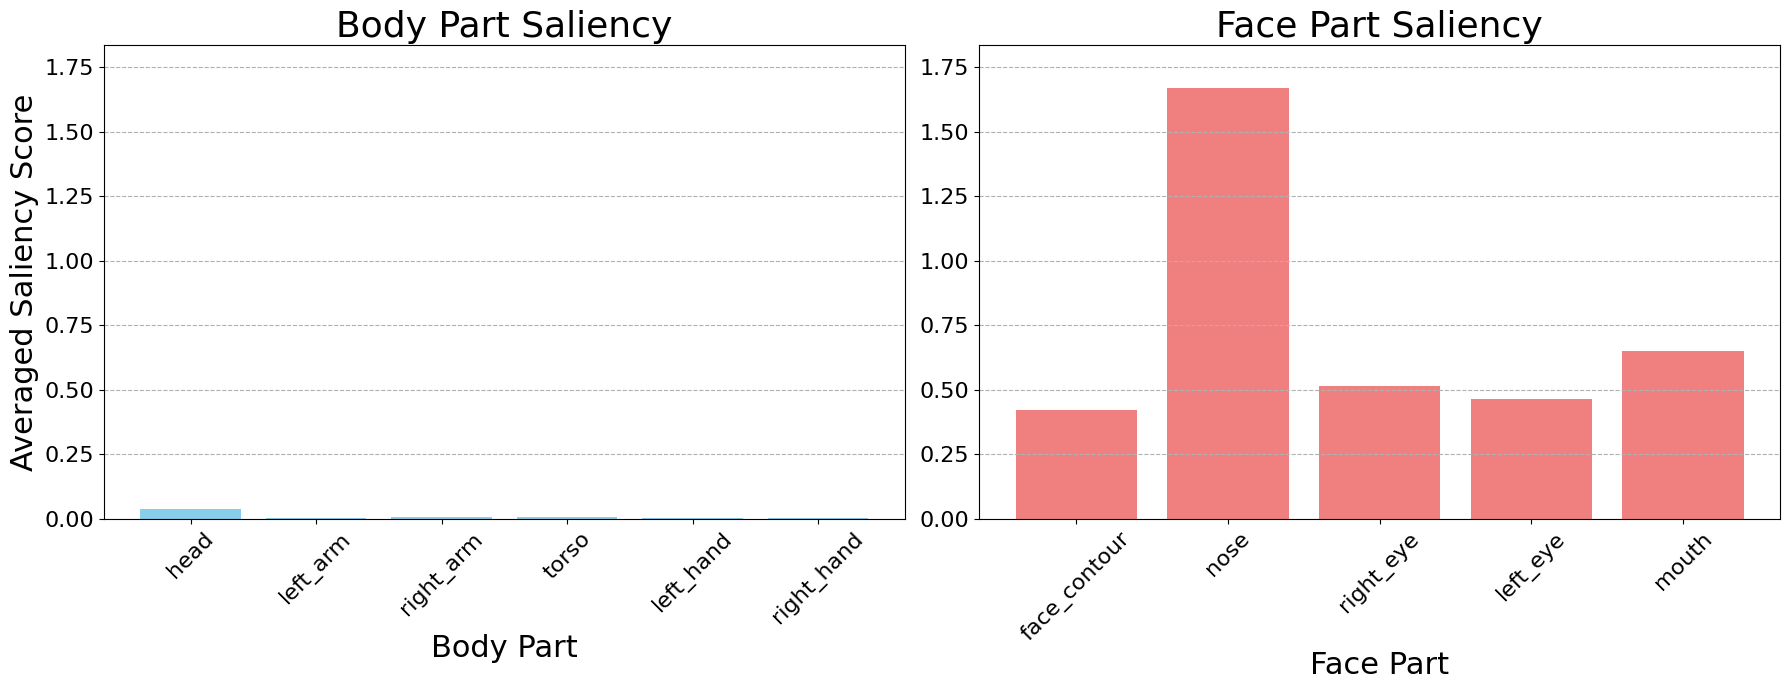

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
# fig.suptitle(
#     f"Aggregated Saliency Distribution for {artist} - {song}",
#     fontsize=30,
#     y=1.05,
# )

# --- Plot 1: Body Parts with corrected method ---
corrected_body_part_names = list(body_part_ig_saliency.keys())
corrected_body_part_values = list(body_part_ig_saliency.values())
axes[0].bar(
    corrected_body_part_names, corrected_body_part_values, color="skyblue"
)
axes[0].set_title("Body Part Saliency", fontsize=26)
axes[0].set_xlabel("Body Part", fontsize=22)
axes[0].set_ylabel("Averaged Saliency Score", fontsize=22)
axes[0].tick_params(axis="x", rotation=45, labelsize=16)
axes[0].tick_params(axis="y", labelsize=16)
axes[0].grid(axis="y", linestyle="--")  # Add horizontal grid lines

# --- Plot 2: Face Parts with corrected method ---
corrected_face_part_names = list(face_part_ig_saliency.keys())
corrected_face_part_values = list(face_part_ig_saliency.values())
axes[1].bar(
    corrected_face_part_names, corrected_face_part_values, color="lightcoral"
)
axes[1].set_title("Face Part Saliency", fontsize=26)
axes[1].set_xlabel("Face Part", fontsize=22)
axes[1].tick_params(axis="x", rotation=45, labelsize=16)
axes[1].tick_params(axis="y", labelsize=16)
axes[1].grid(axis="y", linestyle="--")  # Add horizontal grid lines

# --- Ensure both y-axes have the same scale ---
max_saliency = max(
    max(corrected_body_part_values), max(corrected_face_part_values)
)
axes[0].set_ylim([0, max_saliency * 1.1])
axes[1].set_ylim([0, max_saliency * 1.1])

plt.tight_layout()
plt.show()